<a href="https://colab.research.google.com/github/yenlung/Python-AI-Book/blob/main/%E5%86%92%E9%9A%AA%E5%89%AF%E6%9C%AC04_Stable_Diffusion_%E7%9A%84_LoRA_%E4%BE%86%E4%BA%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LoRA 這個技術出自 Microsoft [這篇論文](https://arxiv.org/abs/2106.09685)。想解決的是現在 AI 模型一個比一個大, 我們想要再加上自己數據再訓練一下, 一方面原本的模型那麼大一般的機器可能根本跑不動; 另一方面也怕新的資料動到原本模型的參數, 可能會破壞原來訓練不錯的地方。

LoRA 就是完全不動原本的參數, 訓練出另一組小很多的參數, 再融入原本的參數中。訓練的時候因為小很多, 於是比訓練原本模型容易很多。又因為沒有動到原本的參數, 也就不太需要擔心毀了原本的模型。更厲害的是, 它也不一定要融入原本使用的 base 模型! 只是自然原則上融入原本的那個模型效果可能比較好, 也比較不會出亂子。

所以 LoRA 的核心就是一組參數, 一般是用 `safetensors` 的格式儲存。我們順便介紹一些名詞, 不管 LoRA 或是一個完整的模型、參數 (我們常常稱一個 `checkpoint`), 儲存的方式基本上是:

* `safetensors`: 一個新的安全存 tensor 的格式
* `ckpt`: 也就是 `checkpoint`

你會看到完整模型通常兩種存法都有, 而 LoRA 比較常用 `safetensors` 這種格式。尤其是模型, 不論哪種格式, 都可以完整一個檔案存起來。順道一提的 Hugging Face 的 `diffusers` 套件不是直接用任何一種格式, 需要轉換。轉換的 script 在 [diffusers 的 GitHub](https://github.com/huggingface/diffusers) 中有提供。

壞消息是, `diffusers` 其實沒有正式支援 LoRA。不過好消息是我們也只需要自己把一個 LoRA 融到我們系統就可以了。因此請大家去找個 LoRA, 我們等一下會以 Stable Diffusion 1.5 示範, 因此最好找 base 是 Stable Diffusion 1.5 版的 (好在這種 LoRA 最多)。

#### 【注意】
請在自己的 Google Drive 建立一個叫 `Lora` 的資料夾, 把你找到以 `.safetensors` 格式的 LoRA 檔案放進去。雖然我們可以每次由自己電腦把 LoRA 檔拉進 Colab 的暫時儲存空間, 但你應該不會想每次都這樣做。

如果希望和範例一模一樣, 我們示範是用 [civita.com](https://civitai.com/) 的 [epi-noise-offset-v2](https://civitai.com/models/13941/epinoiseoffset) 這個 LoRA, 請下載 `epiNoiseoffset_v2.safetensors` 這個檔案, 放到你的 `Lora` 資料夾中。



### 1. 安裝必要套件

你會發現這次我們多裝了 `safetensors` 套件, 顯然就是為了讀入我們的 LoRA 用的。

In [ ]:
!pip install transformers
!pip install diffusers["torch"]
!pip install sentencepiece
!pip install safetensors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 17.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.2 MB/s eta 0:00:00


### 2. 讀入 Stable Diffusion 1.5

我們這次用 Stable Diffusion 1.5, 並採用 DDIM sampler (scheduler)。這是依 LoRA 原作者建議的。

In [ ]:
import torch
from safetensors.torch import load_file
from diffusers import StableDiffusionPipeline
from diffusers import DDIMScheduler

In [ ]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float32)
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


### 3. 連上你的 Google Drive, 讀入 LoRA

執行下面這一段, 會要請你以 Google 帳號認證, 連上 Google Drive。

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/gdrive/


這時你的 `Lora` 資料夾路徑是:

    /content/drive/MyDrive/Lora/

這裡的 `epiNoiseoffset_v2.safetensors` 當然要是你要用的 LoRA 的檔名。

In [ ]:
lora_folder = "/content/drive/MyDrive/Lora/"
model_path = lora_folder + "epiNoiseoffset_v2.safetensors"

state_dict = load_file(model_path)

LORA_PREFIX_UNET = 'lora_unet'
LORA_PREFIX_TEXT_ENCODER = 'lora_te'

alpha = 0.75

visited = []

### 4. 把 LoRA 融入原本的模型中

我們要把 LoRA 融入我們的模型中。等等看來有點長、有點可怕的一段, 其實就是把 LoRA 的權重找出來, 加到原本 base 模型裡。

這段完全是由 [Lora for Diffusers 這個 GitHub](https://github.com/haofanwang/Lora-for-Diffusers) 照抄來的。順道一提, 這個 GitHub 說明不是很長, 但很清楚, 提供很多訊息, 包括之後你想把 `.safetensors` 或 `.checkpoint` 儲存的模型, 轉成 `diffusers` 用的格式要怎麼做。

In [ ]:
# directly update weight in diffusers model
for key in state_dict:
    
    # it is suggested to print out the key, it usually will be something like below
    # "lora_te_text_model_encoder_layers_0_self_attn_k_proj.lora_down.weight"
    
    # as we have set the alpha beforehand, so just skip
    if '.alpha' in key or key in visited:
        continue
        
    if 'text' in key:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_TEXT_ENCODER+'_')[-1].split('_')
        curr_layer = pipe.text_encoder
    else:
        layer_infos = key.split('.')[0].split(LORA_PREFIX_UNET+'_')[-1].split('_')
        curr_layer = pipe.unet

    # find the target layer
    temp_name = layer_infos.pop(0)
    while len(layer_infos) > -1:
        try:
            curr_layer = curr_layer.__getattr__(temp_name)
            if len(layer_infos) > 0:
                temp_name = layer_infos.pop(0)
            elif len(layer_infos) == 0:
                break
        except Exception:
            if len(temp_name) > 0:
                temp_name += '_'+layer_infos.pop(0)
            else:
                temp_name = layer_infos.pop(0)
    
    # org_forward(x) + lora_up(lora_down(x)) * multiplier
    pair_keys = []
    if 'lora_down' in key:
        pair_keys.append(key.replace('lora_down', 'lora_up'))
        pair_keys.append(key)
    else:
        pair_keys.append(key)
        pair_keys.append(key.replace('lora_up', 'lora_down'))
    
    # update weight
    if len(state_dict[pair_keys[0]].shape) == 4:
        weight_up = state_dict[pair_keys[0]].squeeze(3).squeeze(2).to(torch.float32)
        weight_down = state_dict[pair_keys[1]].squeeze(3).squeeze(2).to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down).unsqueeze(2).unsqueeze(3)
    else:
        weight_up = state_dict[pair_keys[0]].to(torch.float32)
        weight_down = state_dict[pair_keys[1]].to(torch.float32)
        curr_layer.weight.data += alpha * torch.mm(weight_up, weight_down)
        
     # update visited list
    for item in pair_keys:
        visited.append(item)

In [ ]:
pipe = pipe.to(torch.float16).to("cuda")
pipe.safety_checker = lambda images, clip_input: (images, False)

### 5. 生成準備工作

這裡我們生一組亂數 seed 出來, 以便於控制。另外寫一個 `combine_imgs` 函數, 讓我們一次生 4 張圖可以同時顯示出來。

In [ ]:
seeds = np.random.randint(0, 100000, 4)
seeds = [int(i) for i in seeds]

In [ ]:
seeds

[81647, 53384, 22009, 8159]

In [ ]:
from PIL import Image

In [ ]:
def combine_imgs(images):
    width, height = images[0].size
    new_img = Image.new('RGB', (width, height))

    w = int(width/2)
    h = int(height/2)

    new_img.paste(images[0].resize((w,h)), (0, 0))
    new_img.paste(images[1].resize((w,h)), (w, 0))
    new_img.paste(images[2].resize((w,h)), (0, h))
    new_img.paste(images[3].resize((w,h)), (w, h))
    return new_img

### 6. 正式開始使用!

首先, 因為我們用 `epiNoiseoffset_v2` 這個 LoRA, 通常會設一下使用的「強度」。一般原作都會有個建議值, 大家也可以自己試試:

    <lora:epiNoiseoffset_v2:1>

當然這段常常是放在後面的, 不過我們為了介紹就放這裡了。

再來我們順便介紹生成時進一步的控制:

* `height`, `weight`: 這很明顯就是圖的高度和寬度
* `num_inference_steps`: 生成去 noise 要進行幾次
* `guidance_scale`: 電腦要多貼近我們的 prompts

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

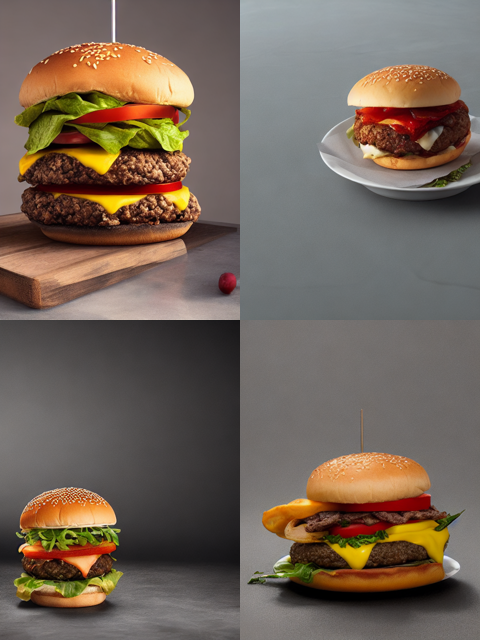

In [ ]:
prompt = "<lora:epiNoiseoffset_v2:1> product shot of ultra realistic juicy cheeseburger against a dark background, two tone lighting, advertisement, octane, unreal"
negative_prompt = "text, error, cropped, duplicate, morbid, mutilated, out of frame, username, watermark, signature"

generator = [torch.Generator().manual_seed(i) for i in seeds]

images = []
num_of_imgs = 4

for i in range(num_of_imgs):
    img = pipe(prompt, negative_prompt=negative_prompt, generator=generator[i],
               height=640, width=480,
               num_inference_steps=30,
               guidance_scale=5
               ).images[0]
    images.append(img)
    
combine_imgs(images)

你可以看看覺得最滿意的, 當然也可以繼續修。

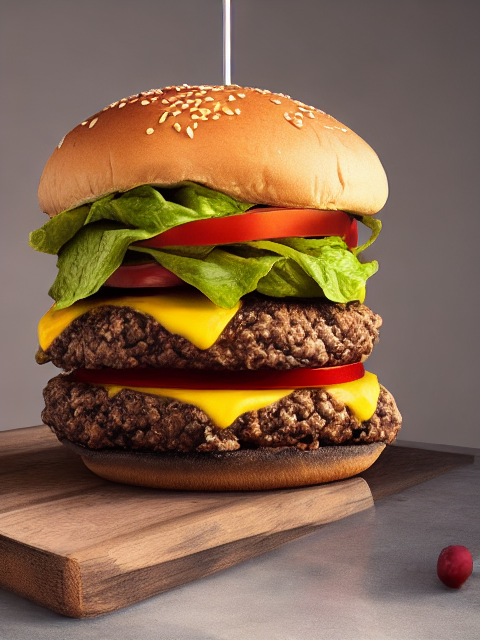

In [ ]:
images[0]